## **1. Import Libraries**
This section imports essential libraries for data manipulation, visualization, preprocessing, and machine learning. Libraries like `pandas`, `matplotlib`, and `scikit-learn` are used extensively for data analysis and model training.

In [4]:
# Import Libraries

# Standard libraries
import numpy as np  # Numerical computations
import math  # Mathematical operations
import random  # Random number generation for reproducibility
import os  # Operating system interactions (e.g., environment variables)

# Data manipulation and visualization
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Data visualization
import matplotlib.colors as mcolors  # For handling colors in plots

# Scikit-learn: Data preprocessing and transformation
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler  # Feature encoding and scaling
from sklearn.compose import make_column_transformer  # Column transformations for preprocessing

# Scikit-learn: Model selection and validation
from sklearn.model_selection import (
    train_test_split,  # Splitting data into training and testing sets
    RandomizedSearchCV,  # Randomized hyperparameter search
    StratifiedKFold,  # Stratified K-Fold cross-validation
    cross_val_score  # Compute cross-validated scores
)

# Scikit-learn: Machine learning models
from sklearn.ensemble import RandomForestClassifier  # Random Forest Classifier
from sklearn.tree import DecisionTreeClassifier  # Decision Tree Classifier
from sklearn.linear_model import LogisticRegression  # Logistic Regression
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors Classifier

# Scikit-learn: Model evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score  # Model performance metrics

# Workflow and pipeline
from sklearn.pipeline import Pipeline  # Building machine learning pipelines

# Deep Learning: TensorFlow/Keras
from keras.models import Sequential, load_model  # Model definition and loading
from keras import layers, initializers, backend as K  # Layers, weight initialization, backend control
from keras.callbacks import EarlyStopping  # Early stopping callback for training
import tensorflow as tf  # TensorFlow backend for Keras

# Set seeds for reproducibility
np.random.seed(42)  # Numpy seed
random.seed(42)  # Python random seed
tf.random.set_seed(42)  # TensorFlow random seed

# Ensure deterministic operations in TensorFlow
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Use deterministic algorithms for GPU
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic CPU/GPU operations

# Keras-specific settings
# manual_variable_initialization(True)  # Manually initialize variables for reproducibility
# K.set_learning_phase(0)  # Disable learning phase to avoid dropout/batch norm during inference

## **2. Define Helper Functions**
The `FolderToDictData` and `FolderToPixelData` functions read text and image data from a specified folder and organize them into dictionaries for further processing.


In [28]:
from PIL import Image
def FolderToDictData(folder_path):
    """
    Reads files in a folder, extracts numerical data, and organizes it into a dictionary.
    
    Args:
        folder_path (str): Path to the folder containing the files.

    Returns:
        tuple: (data_dict, file_names)
            - data_dict: A dictionary where keys are file names (without extension) and values are numpy arrays of file data.
            - file_names: A list of file names (without extensions).
    """
    # Initialize lists for file paths and names
    file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    file_names = [os.path.splitext(f)[0] for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Read file contents
    files_contents = [open(fp, 'r').read() for fp in file_paths]

    # Initialize parameters
    nb_of_features = 7
    data_dict = {}

    # Process each file's content
    for file_name, file_content in zip(file_names, files_contents):
        # Split file content into samples and initialize data array
        samples = file_content.strip().split('\n')
        data = np.zeros((len(samples), nb_of_features))

        # Parse each sample into numerical data
        for i, sample in enumerate(samples):
            d = sample.split(' ')
            if len(d) == nb_of_features + 1:  # Verify data format
                data[i, :] = d[:nb_of_features]  # Extract relevant features

        # Store processed data in dictionary (remove trailing empty rows)
        data_dict[file_name] = data[1:-1,:]

    return data_dict, file_names


def FolderToPixelData(folder_path):
    """
    Converts images in a folder into pixel data stored in a dictionary.

    Args:
        folder_path (str): Path to the folder containing image files.

    Returns:
        dict: A dictionary where keys are file names (without prefixes and extensions)
              and values are NumPy arrays of image pixel data.
    """
    dataX_dict = {}

    # Process each file in the folder
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)  # Construct file path

        if os.path.isfile(file_path):  # Ensure it is a file
            # Extract relevant file name and load image
            key = file_name[3:-4]  # Remove prefix and extension
            image = Image.open(file_path)  # Load image
            pixel_data = np.array(image)  # Convert to NumPy array

            # Store pixel data in dictionary
            dataX_dict[key] = pixel_data

    return dataX_dict


## **3. Load and Preprocess Data**
Here, the patient data and target labels (`Y`) are loaded and processed.


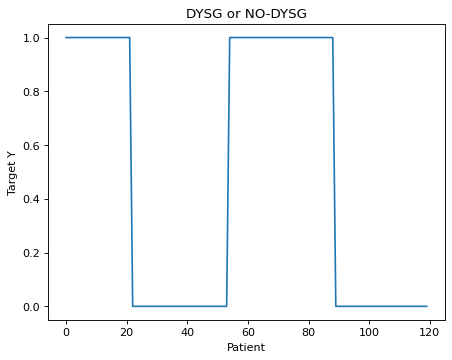

In [29]:
# Load text data
folder_path = './data/txt_data'
data_dict, user_names = FolderToDictData(folder_path)

# Load and preprocess target labels
df = pd.read_excel('./data/dataY.xlsx')
dataY = (df['diag'] != 0).astype(int).values

# Plot target distribution
plt.figure(dpi=80)
plt.plot(dataY)
plt.xlabel('Patient')
plt.ylabel('Target Y')
plt.title('DYSG or NO-DYSG')
plt.show()


## **4. Visualize Patient Data**
This section generates visualizations for features such as X-Y positions, pressure, azimuth, and altitude for a specific patient.


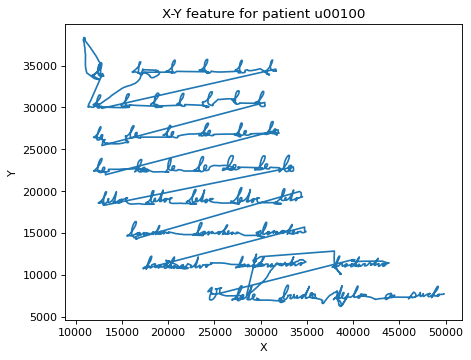

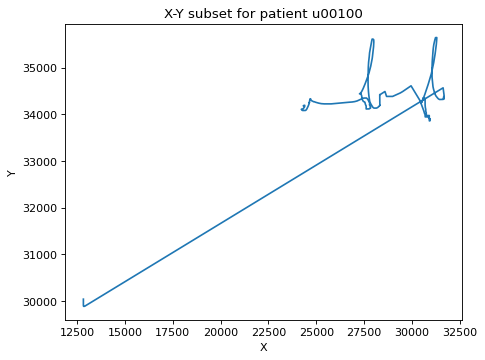

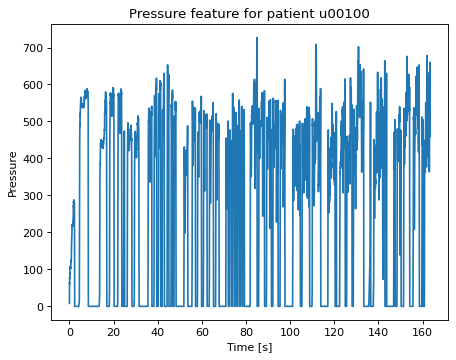

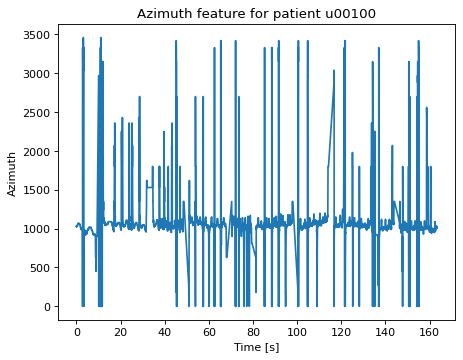

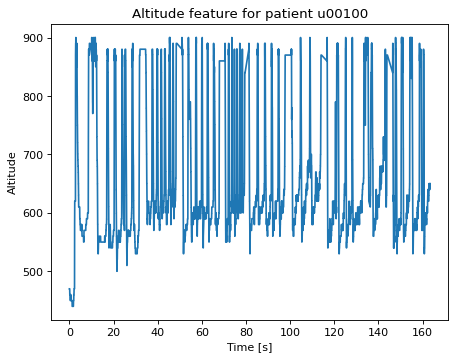

In [30]:
# Visualize X-Y positions for a specific patient
patient_name = 'u00100'
position_x, position_y = data_dict[patient_name][:, 0], data_dict[patient_name][:, 1]

plt.figure(dpi=80)
plt.plot(position_x, position_y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'X-Y feature for patient {patient_name}')
plt.show()

# Visualize a subset of X-Y positions
plt.figure(dpi=80)
plt.plot(position_x[3000:4100], position_y[3000:4100])
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'X-Y subset for patient {patient_name}')
plt.show()

# Plot other features (pressure, azimuth, altitude)
time = data_dict[patient_name][:, 2] - data_dict[patient_name][0, 2]

features = {'Pressure': 6, 'Azimuth': 4, 'Altitude': 5}
for feature_name, col in features.items():
    plt.figure(dpi=80)
    plt.plot(time * 1e-3, data_dict[patient_name][:, col])
    plt.xlabel('Time [s]')
    plt.ylabel(feature_name)
    plt.title(f'{feature_name} feature for patient {patient_name}')
    plt.show()


## **5. Save and Download X-Y Plots**
(Optional) Generate and download X-Y plots for all patients.


In [39]:
# # Uncomment and run to save X-Y plots
import os

# Ensure the './data' directory exists
os.makedirs('./data/images_data/all', exist_ok=True)

# Loop through user names and save the plots
for user_name in user_names:
    plt.figure(dpi=80)
    plt.axis('off')  # Hide axes
    position_x, position_y = data_dict[user_name][:, 0], data_dict[user_name][:, 1]
    plt.plot(position_x, position_y)

    # Save the plot to the './data/images_data' directory
    file_path = f'./data/images_data/all/xy_{user_name}.png'
    plt.savefig(file_path)
    plt.close()


## **6. Data for Contact Only**
We extract data points where contact is recorded (data_dict[:, 3] == 1) and store them in `data_contact` dictionary.


In [51]:
data_contact = {}
nb_of_features = 7  # Number of features in the data

for patient in data_dict:
    # Count the number of contact points (where index 3 equals 1)
    nb_of_contacts = int(np.sum(data_dict[patient][:, 3]))  
    data_contact[patient] = np.zeros([nb_of_contacts, nb_of_features])  # Initialize empty array for contact data
    
    # Fill the `data_contact` with the contact data
    k = 0
    for i in range(len(data_dict[patient])):
        if data_dict[patient][i, 3] == 1:  # Check if it's a contact data point
            data_contact[patient][k, :] = data_dict[patient][i, :]
            k += 1


#### Plot X-Y Positions for Contact Data

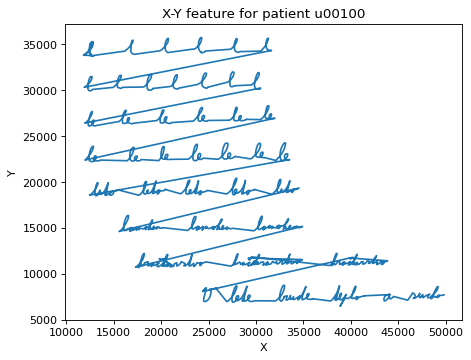

In [52]:
fig = plt.figure(dpi=80)
position_x = data_contact[patient_name][:, 0]
position_y = data_contact[patient_name][:, 1]
plt.plot(position_x, position_y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'X-Y feature for patient {patient_name}')
plt.show()

#### Plot Pressure for Contact Data

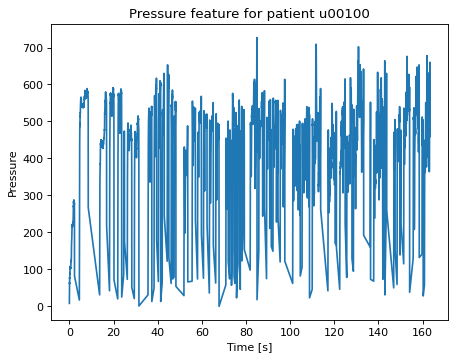

In [53]:
fig = plt.figure(dpi=80)
time = data_contact[patient_name][:, 2] - data_contact[patient_name][0, 2]  # Time in milliseconds
pressure = data_contact[patient_name][:, 6]
plt.plot(time * 1e-3, pressure)  # Convert time to seconds
plt.xlabel('Time [s]')
plt.ylabel('Pressure')
plt.title(f'Pressure feature for patient {patient_name}')
plt.show()

In [54]:
# # Uncomment and run to save X-Y plots
import os

# Ensure the './data' directory exists
os.makedirs('./data/images_data/contact', exist_ok=True)

# Loop through user names and save the plots
for user_name in user_names:
    plt.figure(dpi=80)
    plt.axis('off')  # Hide axes
    position_x, position_y = data_contact[user_name][:, 0], data_contact[user_name][:, 1]
    plt.plot(position_x, position_y)

    # Save the plot to the './data/images_data' directory
    file_path = f'./data/images_data/contact/xy_{user_name}.png'
    plt.savefig(file_path)
    plt.close()


## **7. Data for Air Only**
Similarly, we extract data points where there is no contact (data_dict[:, 3] == 0) and store them in `data_on_air`.


In [55]:
data_on_air = {}

for patient in data_dict:
    # Count the number of air data points (where index 3 equals 0)
    nb_of_data_on_air = int(np.count_nonzero(data_dict[patient][:, 3] == 0))  
    data_on_air[patient] = np.zeros([nb_of_data_on_air, nb_of_features])  # Initialize empty array for air data
    
    # Fill the `data_on_air` with the air data
    k = 0
    for i in range(len(data_dict[patient])):
        if data_dict[patient][i, 3] == 0:  # Check if it's air data
            data_on_air[patient][k, :] = data_dict[patient][i, :]
            k += 1

#### Plot X-Y Positions for Air Data

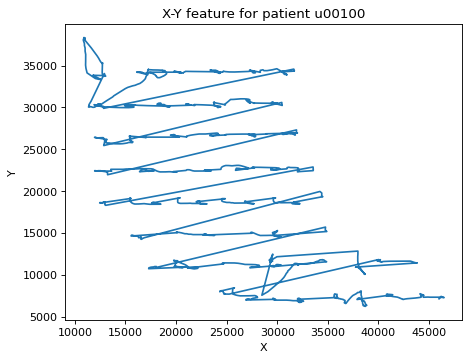

In [56]:
fig = plt.figure(dpi=80)
position_x = data_on_air[patient_name][:, 0]
position_y = data_on_air[patient_name][:, 1]
plt.plot(position_x, position_y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'X-Y feature for patient {patient_name}')
plt.show()

#### Plot Pressure for Air Data

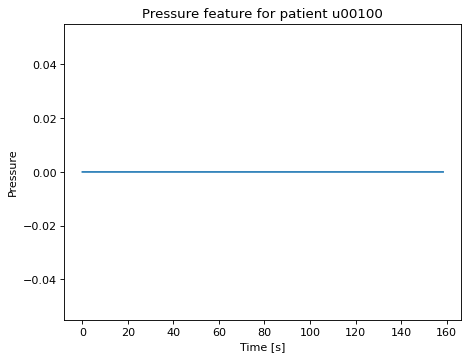

In [57]:
fig = plt.figure(dpi=80)
time = data_on_air[patient_name][:, 2] - data_on_air[patient_name][0, 2]  # Time in milliseconds
pressure = data_on_air[patient_name][:, 6]
plt.plot(time * 1e-3, pressure)  # Convert time to seconds
plt.xlabel('Time [s]')
plt.ylabel('Pressure')
plt.title(f'Pressure feature for patient {patient_name}')
plt.show()

In [58]:
# # Uncomment and run to save X-Y plots
import os

# Ensure the './data' directory exists
os.makedirs('./data/images_data/on_air', exist_ok=True)

# Loop through user names and save the plots
for user_name in user_names:
    plt.figure(dpi=80)
    plt.axis('off')  # Hide axes
    position_x, position_y = data_on_air[user_name][:, 0], data_on_air[user_name][:, 1]
    plt.plot(position_x, position_y)

    # Save the plot to the './data/images_data' directory
    file_path = f'./data/images_data/on_air/xy_{user_name}.png'
    plt.savefig(file_path)
    plt.close()


## **8. Generate Data from Images**

### Function to Load and Split Image Data
The function takes a folder path and the indices for training and testing, and splits image data accordingly.

It also prints the shape of the image data and the number of classes in the training and test sets.


In [59]:
import random

def SplitDataFromImages(folder_path, train_indices, test_indices):
    dataX_dict = FolderToPixelData(folder_path)  # Assuming FolderToPixelData is a function that loads image data into a dictionary

    # Display the shape of the pixel data (height, width, channels)
    print("Shape of pixel data:", dataX_dict[user_names[0]].shape)

    # Convert from dataX_dict to dataX
    dataX = np.zeros([len(dataX_dict), dataX_dict[user_names[0]].shape[0], dataX_dict[user_names[0]].shape[1], dataX_dict[user_names[0]].shape[2]])
    for i in range(0, len(user_names)):
        dataX[i, :, :, :] = dataX_dict[user_names[i]]

    # Split Data into train and test sets based on the provided indices
    X_data = dataX[train_indices]
    X_test = dataX[test_indices]
    Y_data = dataY[train_indices]  # Assuming dataY is pre-defined elsewhere
    Y_test = dataY[test_indices]

    # Print data sizes and class distribution
    print(f"Train data size = {X_data.shape[0]}")
    print(f"Test data size = {X_test.shape[0]}")

    print("Number of DYS/NON-DYS in Train data: ", end=' ')
    print(f"{np.count_nonzero(Y_data == 1)} / {np.count_nonzero(Y_data == 0)}")

    print("Number of DYS/NON-DYS in Test data: ", end=' ')
    print(f"{np.count_nonzero(Y_test == 1)} / {np.count_nonzero(Y_test == 0)}")

    return dataX, dataY, X_data, X_test, Y_data, Y_test

### Generate Random Indices for Train and Test Data
We generate random indices to create a balanced train-test split, with equal proportions of 'DYS' and 'NON-DYS' cases.


In [60]:
n_test = 10
test_indices = []
while len(test_indices) < n_test:
    index = random.randint(0, 119)
    if dataY[index] == 0 and test_indices.count(0) < n_test / 2:
        test_indices.append(index)
    if dataY[index] == 1 and test_indices.count(1) < n_test / 2:
        test_indices.append(index)

# Generate train indices by excluding test indices
train_indices = [i for i in range(120) if i not in test_indices]

# Print test patient names and their indices
print("The patients in the test data are: ", end=' ')
for i in test_indices:
    print(user_names[i], end=' ')
print()

# Print the train indices
print(train_indices)

The patients in the test data are:  u00148 u00163 u00186 u00115 u00022 u00124 u00091 u00013 u00011 u00022 
[0, 1, 2, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119]


### Load and Split All Image Data
We use the SplitDataFromImages function to load and split data for the full set of images.

In [61]:
folder_path = './data/images_data/all'
dataX, dataY, X_data, X_test, Y_data, Y_test = SplitDataFromImages(folder_path, train_indices, test_indices)

Shape of pixel data: (384, 512, 4)
Train data size = 111
Test data size = 10
Number of DYS/NON-DYS in Train data:  50 / 61
Number of DYS/NON-DYS in Test data:  8 / 2


### Load and Split Contact-Only Image Data
Now, we split the contact-only images, using the same train-test indices.

In [62]:
folder_path_contact = './data/images_data/contact'
dataX_contact, dataY_contact, X_data_contact, X_test_contact, Y_data_contact, Y_test_contact = SplitDataFromImages(folder_path_contact, train_indices, test_indices)

Shape of pixel data: (384, 512, 4)
Train data size = 111
Test data size = 10
Number of DYS/NON-DYS in Train data:  50 / 61
Number of DYS/NON-DYS in Test data:  8 / 2


### Load and Split On-Air-Only Image Data
Finally, we split the on-air images, again using the same indices for consistency.

In [63]:
folder_path_on_air = './data/images_data/on_air'
dataX_on_air, dataY_on_air, X_data_on_air, X_test_on_air, Y_data_on_air, Y_test_on_air = SplitDataFromImages(folder_path_on_air, train_indices, test_indices)

Shape of pixel data: (384, 512, 4)
Train data size = 111
Test data size = 10
Number of DYS/NON-DYS in Train data:  50 / 61
Number of DYS/NON-DYS in Test data:  8 / 2


### Data Augmentation Function

This function performs data augmentation and rescaling on image datasets. It standardizes images by rescaling pixel values to a range of [0, 1], applies various augmentation techniques (shear, zoom, etc.), and then combines the augmented and rescaled data for training. 

The function:
1. Converts data to float32 format.
2. Applies augmentation and rescaling using `ImageDataGenerator`.
3. Generates augmented and rescaled datasets for training and testing.
4. Plots a few sample images from the augmented and rescaled data.
5. Concatenates the augmented and rescaled data for training.

It returns the augmented training data, along with rescaled test data for evaluation.


C:\Users\hatoui\AppData\Local\Temp\ipykernel_18752\81532578.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_aug[count], Y_aug[count] = X_batch, y_batch


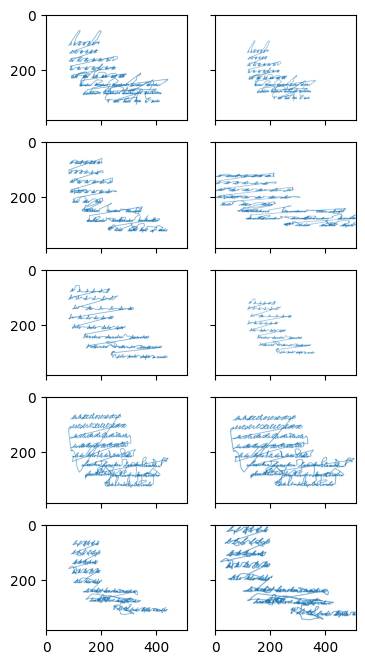

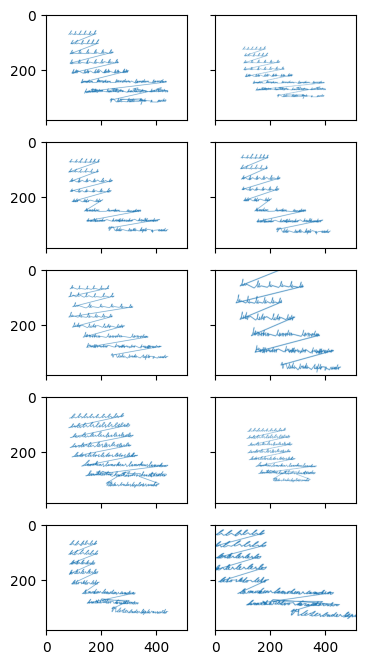

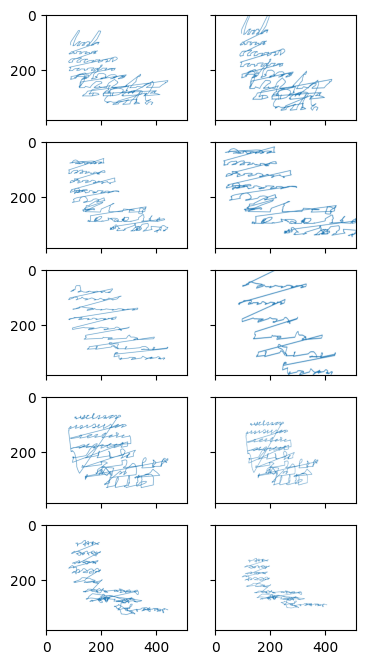

In [64]:
def DataAugmentation(X_data, Y_data, X_test, Y_test):
    # Import necessary modules
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    import matplotlib.pyplot as plt

    # Convert data to float32 for further processing
    X_data, X_test = X_data.astype('float32'), X_test.astype('float32')

    # Initialize data generators for rescaling and augmentation
    datagen_rescale = ImageDataGenerator(rescale=1./255)
    datagen_aug = ImageDataGenerator(rescale=1./255, shear_range=0.5, zoom_range=0.5, horizontal_flip=False)

    # Fit the data generators to the datasets
    datagen_rescale.fit(X_data), datagen_rescale.fit(X_test), datagen_aug.fit(X_data)

    # Helper function to apply data generator to batches and store results
    def apply_datagen(datagen, X, Y):
        X_aug, Y_aug = np.zeros(X.shape), np.zeros(Y.shape)
        count = 0
        for X_batch, y_batch in datagen.flow(X, Y, batch_size=1, shuffle=False):
            X_aug[count], Y_aug[count] = X_batch, y_batch
            count += 1
            if count == X.shape[0]: break
        return X_aug, Y_aug

    # Augment and rescale training and test data
    X_train_aug, Y_train_aug = apply_datagen(datagen_aug, X_data, Y_data)
    X_train_rescaled, Y_train_rescaled = apply_datagen(datagen_rescale, X_data, Y_data)
    X_test_rescaled, Y_test_rescaled = apply_datagen(datagen_rescale, X_test, Y_test)

    # Plot a few augmented and rescaled images side by side
    fig, ax = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(4, 8))
    for i in range(5):
        ax[i][0].imshow(X_train_rescaled[i], cmap='gray')
        ax[i][1].imshow(X_train_aug[i], cmap='gray')
    plt.show()

    # Concatenate augmented and rescaled data for final training set
    X_train_concat = np.concatenate((X_train_rescaled, X_train_aug))
    Y_train_concat = np.concatenate((Y_train_rescaled, Y_train_aug))

    return X_train_concat, Y_train_concat, X_test_rescaled, Y_test_rescaled

# Applying DataAugmentation to different datasets
X_data_augmented, Y_data_augmented, X_test, Y_test = DataAugmentation(X_data, Y_data, X_test, Y_test)
X_data_contact_augmented, Y_data_contact_augmented, X_test_contact, Y_test_contact = DataAugmentation(X_data_contact, Y_data_contact, X_test_contact, Y_test_contact)
X_data_on_air_augmented, Y_data_on_air_augmented, X_test_on_air, Y_test_on_air = DataAugmentation(X_data_on_air, Y_data_on_air, X_test_on_air, Y_test_on_air)


## **9. Define Function - Nested Cross-Validation for Hyperparameter Tuning**
This function performs a nested cross-validation process. The outer loop splits the data into training and validation sets, 

while the inner loop performs another level of cross-validation to find the best hyperparameters (e.g., batch size, epochs).

The function also calculates evaluation metrics such as accuracy, loss, sensitivity, specificity, and F1 score.


In [65]:
# ## Train Function
# This function initializes, compiles, and trains a CNN model. It then evaluates the model and returns the trained model, accuracy, and loss.

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

def Train(X_data, Y_data, epochs, batch_size):
    # Initialising the CNN
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Convolution2D(32, 3, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Convolution2D(64, 3, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Convolution2D(128, 3, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten the feature maps
    model.add(tf.keras.layers.Flatten())
    
    # Fully connected layers
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    # Compiling the CNN
    model_optimizer = 'adam'
    model_loss = 'binary_crossentropy'
    model_metrics = ['accuracy']
    
    # Define early stopping criteria
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, restore_best_weights=True)
    
    model.compile(optimizer=model_optimizer, loss=model_loss, metrics=model_metrics)
    
    # Train the model
    history = model.fit(X_data, Y_data, epochs=min(epochs, 50), batch_size=batch_size)
    
    # Calculate accuracy and store the score
    train_accuracy = model.evaluate(X_data, Y_data, verbose=0)[1]
    train_loss = model.evaluate(X_data, Y_data, verbose=0)[0]
    
    return model, train_accuracy, train_loss


In [66]:
# ## Cross Validation for Hyperparameter Tuning
# This function performs k-fold cross-validation with the training and validation data. It initializes, compiles, and trains a CNN on each fold 
# and stores the evaluation metrics (accuracy, loss). It also tunes the hyperparameter batch size for each fold if provided as a list.

from typing import Union
from sklearn.model_selection import StratifiedKFold

def CrossValidation(X_data, Y_data, n_splits_fold=10, epochs=10, batch_size: Union[int, list] = None):
    n_splits = n_splits_fold
    skf = StratifiedKFold(n_splits=n_splits)
    split_object = skf.split(X_data, Y_data)

    count_fold = 0
    train_scores, val_scores, train_losses, val_losses = [], [], [], []
    models = []
    
    # Check if batch_size is a list for parameter tuning
    if isinstance(batch_size, int):
        parameter_tuning = False
    elif isinstance(batch_size, list):
        parameter_tuning = True

    # Iterate through stratified k-fold splits
    for train_index, val_index in split_object:
        count_fold += 1
        print(f"Fold: {count_fold}")
        X_train, X_val = X_data[train_index], X_data[val_index]
        Y_train, Y_val = Y_data[train_index], Y_data[val_index]

        # Initialize CNN
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Convolution2D(32, 3, 3, activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Convolution2D(64, 3, 3, activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Convolution2D(128, 3, 3, activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        
        # Flatten the feature maps
        model.add(tf.keras.layers.Flatten())
        
        # Fully connected layers
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))
        model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
        
        # Compiling the CNN
        if parameter_tuning:
            set_batch_size = batch_size[count_fold-1]
        else:
            set_batch_size = batch_size
        model_optimizer = 'adam'
        model_loss = 'binary_crossentropy'
        model_metrics = ['accuracy']
        
        # Define early stopping criteria
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, restore_best_weights=True)
        
        model.compile(optimizer=model_optimizer, loss=model_loss, metrics=model_metrics)
        
        # Train the model
        history = model.fit(X_train, Y_train, epochs=epochs, batch_size=set_batch_size, validation_data=(X_val, Y_val), callbacks=[early_stopping])

        # Get the best epoch and store metrics
        best_epoch = early_stopping.stopped_epoch - early_stopping.patience
        print(f"Best epoch: {best_epoch}")
        
        train_accuracy = model.evaluate(X_train, Y_train, verbose=0)[1]
        train_scores.append(train_accuracy)
        val_accuracy = model.evaluate(X_val, Y_val, verbose=0)[1]
        val_scores.append(val_accuracy)
        
        train_loss = model.evaluate(X_train, Y_train, verbose=0)[0]
        train_losses.append(train_loss)
        validation_loss = model.evaluate(X_val, Y_val, verbose=0)[0]
        val_losses.append(validation_loss)
        
        models.append(model)
    
    # Print scores for each fold
    for i in range(count_fold):
        print(f"Fold {i+1}: Train Accuracy = {train_scores[i]:.4f}, Train Loss = {train_losses[i]:.4f}, "
              f"Validation Accuracy = {val_scores[i]:.4f}, Validation Loss = {val_losses[i]:.4f}")
    
    return models, best_epoch, train_scores, val_scores, train_losses, val_losses


In [67]:
from typing import Union

def NestedCrossValidation_ParameterTuning(X_data, Y_data, n_splits_fold_1 = 5, n_splits_fold_2 = 2, epochs = 10, batch_size : Union[int, list] = None):
    n_splits_1 = n_splits_fold_1
    skf = StratifiedKFold(n_splits=n_splits_1)
    split_object = skf.split(X_data, Y_data)

    count_fold = 0
    # Initialize lists to store results from each fold
    train_scores, val_scores, train_losses, val_losses = [], [], [], []
    models, batch_sizes, epochses = [], [], []
    sensitivities, specificities, f1_scores = [], [], []

    # Outer Loop for Stratified K-Fold Cross Validation
    for train_index, val_index in split_object:
        count_fold += 1
        print(f"Fold 1: {count_fold}__________________________________________________________________________________")
        X_train, X_val = X_data[train_index], X_data[val_index]
        Y_train, Y_val = Y_data[train_index], Y_data[val_index]

        # Perform inner cross-validation to tune hyperparameters
        models_2, best_epoch, train_scores_2, val_scores_2, train_losses_2, val_losses_2 = CrossValidation(
            X_train, Y_train, n_splits_fold=n_splits_fold_2, epochs=epochs, batch_size=batch_size)
    
        # Select Best Model and Hyperparameters
        best_model_index = val_scores_2.index(max(val_scores_2))
        model = models_2[best_model_index]

        # Determine best batch size based on the model index
        if isinstance(batch_size, int):
            best_batch_size = batch_size
        elif isinstance(batch_size, list):
            best_batch_size = batch_size[best_model_index]

        # Train the selected model with the best batch size
        model, train_accuracy, train_loss = Train(X_train, Y_train, epochs=best_epoch, batch_size=best_batch_size)

        # Evaluate Model on Validation Data
        validation_loss, val_accuracy = model.evaluate(X_test, Y_test)
        print("Validation Loss:", validation_loss)
        print("Validation Accuracy:", val_accuracy)

        # Store metrics for training and validation
        train_scores.append(train_accuracy)
        val_scores.append(val_accuracy)
        train_losses.append(train_loss)
        val_losses.append(validation_loss)

        # Store the trained model and hyperparameters
        models.append(model)
        batch_sizes.append(best_batch_size)
        epochses.append(best_epoch)
        
        # Calculate Evaluation Metrics
        prob_AD = model.predict(X_val)
        y_pred_class = np.round(prob_AD).ravel()  # Convert probabilities to classes (0 or 1)

        # Calculate TP, TN, FP, FN
        TP = np.sum((Y_val == 1) & (y_pred_class == 1))
        TN = np.sum((Y_val == 0) & (y_pred_class == 0))
        FP = np.sum((Y_val == 0) & (y_pred_class == 1))
        FN = np.sum((Y_val == 1) & (y_pred_class == 0))

        # Calculate Sensitivity, Specificity, and F1 Score
        epsilon = 1e-7  # Small constant to avoid division by zero
        sensitivity = TP / (TP + FN + epsilon)
        specificity = TN / (TN + FP + epsilon)

        f1 = f1_score(Y_val, y_pred_class)  # F1 score
        f1_scores.append(f1)

        sensitivities.append(sensitivity)
        specificities.append(specificity)

    # Print Final Results for Each Fold
    for i in range(count_fold):
            print(f"Fold {i+1}: Train Accuracy = {train_scores[i]:.4f}, Train Loss = {train_losses[i]:.4f}, "
                  f"Validation Accuracy = {val_scores[i]:.4f}, Validation Loss = {val_losses[i]:.4f}")

    return models, batch_sizes, epochses, train_scores, val_scores, train_losses, val_losses, sensitivities, specificities, f1_scores

## **10. Model Evaluation Plots**

This function generates a series of plots to evaluate the performance of a machine learning model during training. It includes:

1. **Accuracy by Fold**: Plots the training and validation accuracy across different folds.
2. **Accuracy by Epoch**: Displays the training and validation accuracy at each epoch.
3. **Loss by Fold**: Shows the training and validation loss across different folds, with a limited y-axis for better visualization.
4. **Loss by Epoch**: Visualizes the training and validation loss at each epoch, with a controlled y-axis range to improve clarity.

The plots are displayed using Matplotlib, providing insights into the model's learning behavior and potential overfitting or underfitting.


In [68]:
import matplotlib.pyplot as plt

def EvaluationPlots(train_scores, val_scores, train_accuracy_per_epochs, val_accuracy_per_epochs, train_losses, val_losses, train_loss_per_epochs, val_loss_per_epochs):
    fig = plt.figure(figsize=(8, 4))

    # Plot training vs validation accuracy by fold
    plt.subplot(2, 2, 1)
    plt.plot(train_scores, label='Training Accuracy')
    plt.plot(val_scores, label='Validation Accuracy')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.tight_layout()
    plt.legend()

    # Plot training vs validation accuracy per epoch
    if train_accuracy_per_epochs:
        plt.subplot(2, 2, 2)
        plt.plot(train_accuracy_per_epochs, label='Training Accuracy')
        plt.plot(val_accuracy_per_epochs, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Epoch-wise Accuracy')
        plt.tight_layout()
        plt.legend()

    # Plot training vs validation loss by fold
    plt.subplot(2, 2, 3)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.ylim(0, min(2, max(max(train_losses), max(val_losses))))  # Limit y-axis for better visualization
    plt.xlabel('Fold')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.tight_layout()

    # Plot training vs validation loss per epoch
    if train_loss_per_epochs:
        plt.subplot(2, 2, 4)
        plt.plot(train_loss_per_epochs, label='Training Loss')
        plt.plot(val_loss_per_epochs, label='Validation Loss')
        plt.ylim(0, min(2, max(max(train_loss_per_epochs), max(val_loss_per_epochs))))  # Limit y-axis for better visualization
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Epoch-wise Loss')
        plt.legend()
        plt.tight_layout()

    plt.show()  # Display the plots


## **11. Apply Nested Cross-Validation with Parameter Tuning**

### **All Data Augmented**

This script performs nested cross-validation with parameter tuning to evaluate a deep learning model on augmented data. The process involves training multiple models with different batch sizes and epochs, evaluating them using various metrics (accuracy, loss, sensitivity, specificity, and F1 score), and selecting the best model based on validation performance.

#### Key Steps:
1. **Nested Cross-Validation**: The model undergoes a cross-validation process where two splits (outer and inner) are used for training and validation.
2. **Parameter Tuning**: Batch sizes and epochs are optimized to find the best-performing configuration for the model.
3. **Model Evaluation**: The models are evaluated on training and validation sets for each fold, and the best model is retrained on the full dataset.
4. **Test Evaluation**: After training, the best model is evaluated on a separate test set to calculate final accuracy, sensitivity, specificity, and F1 score.
5. **Results Visualization**: The performance metrics across folds are plotted to assess model stability.
6. **Metrics Calculation**: Sensitivity and specificity are calculated for detecting Alzheimer's patients (DYS) and healthy individuals (non-DYS), along with average F1 score.
7. **Store Results**: All relevant model 


In [69]:
# All Data Augmented - Nested CV Parameter Tuning
# Perform Cross Validation with parameter tuning and model evaluation

# Set parameters for training and cross-validation
epochs = 100
batch_size = [1, 8, 8, 8, 16, 16]
n_splits_1, n_splits_2 = 6, 5

# Run nested cross-validation with parameter tuning
models, batch_sizes, epochses, train_scores, val_scores, train_losses, val_losses, sensitivities, specificities, f1_scores = NestedCrossValidation_ParameterTuning(
    X_data_augmented, Y_data_augmented, n_splits_fold_1=n_splits_1, n_splits_fold_2=n_splits_2, epochs=epochs, batch_size=batch_size)

# Plot evaluation metrics
EvaluationPlots(train_scores, val_scores, [], [], train_losses, val_losses, [], [])

# Compute and display average training/validation scores and losses
avg_train_score = np.mean(train_scores)
avg_val_score = np.mean(val_scores)
print(f'Average Training Score: {avg_train_score}\nAverage Validation Score: {avg_val_score}')

avg_train_loss = np.mean(train_losses)
avg_val_loss = np.mean(val_losses)
print(f'Average Training Loss: {avg_train_loss}\nAverage Validation Loss: {avg_val_loss}')

# Calculate and print the average sensitivity, specificity, and F1-score
epsilon = 1e-7
average_dys_sensitivity = np.mean(sensitivities)
average_healthy_specificity = np.mean(specificities)
average_f1_score = np.mean(f1_scores)

print(f"Average DYS Sensitivity: {average_dys_sensitivity}")
print(f"Average Non-DYS Specificity: {average_healthy_specificity}")
print(f"Average F1-Score: {average_f1_score}")

# Find the best model and its hyperparameters
best_model_index = np.argmax(val_scores)
best_model = models[best_model_index]
best_batch_size = batch_sizes[best_model_index]
best_epoch = epochses[best_model_index]
print(f"Best Model Index: {best_model_index}\nBest Batch Size: {best_batch_size}\nBest Epochs: {best_epoch}")

# Retrain the best model
model, train_accuracy, train_loss = Train(X_data_augmented, Y_data_augmented, epochs=best_epoch, batch_size=best_batch_size)
print(f"Train Accuracy: {train_accuracy}\nTrain Loss: {train_loss}")

# Evaluate on Test Data
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}\nTest Accuracy: {accuracy}")

# Calculate test class predictions
prob_y = model.predict(X_test)
y_pred_class = np.round(prob_y).ravel()

# Calculate TP, TN, FP, FN
TP = np.sum((Y_test == 1) & (y_pred_class == 1))
TN = np.sum((Y_test == 0) & (y_pred_class == 0))
FP = np.sum((Y_test == 0) & (y_pred_class == 1))
FN = np.sum((Y_test == 1) & (y_pred_class == 0))

# Calculate and print sensitivity and specificity
sensitivity = TP / (TP + FN + epsilon)
specificity = TN / (TN + FP + epsilon)
print(f"DYS Sensitivity: {sensitivity}\nNon-DYS Specificity: {specificity}")

# Initialize a dictionary for storing results if not already initialized
if 'params_dict' not in globals():
    params_dict = {}

# Store model and metrics for "nested_all_data_augmented"
params_dict["nested_all_data_augmented"] = {
    "models": models,
    "train_scores": train_scores,
    "val_scores": val_scores,
    "train_losses": train_losses,
    "val_losses": val_losses,
    "test_score": accuracy,
    "test_loss": loss,
    "sensitivities": sensitivities,
    "specificities": specificities,
    "f1_scores": f1_scores
}

Fold 1: 1__________________________________________________________________________________
Fold: 1
Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4680 - loss: 0.7074 - val_accuracy: 0.4595 - val_loss: 0.6872
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6258 - loss: 0.6811 - val_accuracy: 0.7568 - val_loss: 0.6634
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7236 - loss: 0.6421 - val_accuracy: 0.7838 - val_loss: 0.5383
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7722 - loss: 0.5641 - val_accuracy: 0.7838 - val_loss: 0.5365
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7847 - loss: 0.5210 - val_accuracy: 0.7838 - val_loss: 0.5159
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7937 - loss: 0.4987 - val_accuracy: 0.7568 - val_loss: 0.5295
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8171 - loss: 0.4283 - val_accuracy: 0.8108 - val_loss: 0.5

KeyboardInterrupt: 

### **Contact Data Augmented**

This script performs a nested cross-validation process to tune model parameters on augmented contact data. The primary goal is to evaluate model performance across different training and validation folds, and calculate relevant metrics like accuracy, loss, sensitivity, and specificity.

#### Steps:
1. **Hyperparameter Setup**: 
   - The number of epochs and batch size are predefined, along with the number of splits for cross-validation.
   
2. **Model Training and Evaluation**:
   - A nested cross-validation is run on the augmented contact dataset to train the model, using multiple folds for both outer and inner cross-validation.
   
3. **Plotting**:
   - Accuracy and loss curves for training and validation sets are visualized using the `EvaluationPlots` function.
   
4. **Results Calculation**:
   - Average training and validation scores, as well as losses, are calculated and printed.
   
5. **Best Model Selection**:
   - The best model is selected based on the highest validation score and evaluated on test data.
   
6. **Results Storage**:
   - All results, including model performance and metrics, are stored in dictionaries for further analysis or comparison.

### Outputs:
- Average training and validation scores, losses, sensitivity, specificity.
- Best model based on validation performance.
- Test loss and accuracy after evaluating the best model on the test set.


In [70]:
# Title: Contact Data - Nested CV Augmented

# Hyperparameters
epochs, batch_size = 100, 16
n_splits_1, n_splits_2 = 5, 2

# Run Nested Cross Validation with augmented contact data
models, train_scores, val_scores, train_losses, val_losses, sensitivities, specificities = NestedCrossValidation_ParameterTuning(
    X_data_contact_augmented, Y_data_contact_augmented, n_splits_fold_1=n_splits_1, n_splits_fold_2=n_splits_2, epochs=epochs, batch_size=batch_size
)

# Plot the training and validation results
EvaluationPlots(train_scores, val_scores, [], [], train_losses, val_losses, [], [])

# Calculate and print average training and validation scores
avg_train_score, avg_val_score = np.mean(train_scores), np.mean(val_scores)
avg_train_loss, avg_val_loss = np.mean(train_losses), np.mean(val_losses)
print(f'Avg Training Score: {avg_train_score} | Avg Validation Score: {avg_val_score}')
print(f'Avg Training Loss: {avg_train_loss} | Avg Validation Loss: {avg_val_loss}')

# Get the best model and evaluate on test data
best_model_index = val_scores.index(max(val_scores))
best_model = models[best_model_index]
loss, accuracy = best_model.evaluate(X_test_contact, Y_test_contact)
print(f'Test Loss: {loss} | Test Accuracy: {accuracy}')

# Store model and metrics for "nested_contact_data_augmented"
params_dict["nested_contact_data_augmented"] = {
    "models": models,
    "train_scores": train_scores,
    "val_scores": val_scores,
    "train_losses": train_losses,
    "val_losses": val_losses,
    "test_score": accuracy,
    "test_loss": loss,
    "sensitivities": sensitivities,
    "specificities": specificities
}


Fold 1: 1__________________________________________________________________________________
Fold: 1
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.5381 - loss: 0.6993 - val_accuracy: 0.5506 - val_loss: 0.6899
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4833 - loss: 0.6974 - val_accuracy: 0.6180 - val_loss: 0.6915
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5230 - loss: 0.6931 - val_accuracy: 0.7416 - val_loss: 0.6897
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6881 - loss: 0.6901 - val_accuracy: 0.6292 - val_loss: 0.6870
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6831 - loss: 0.6878 - val_accuracy: 0.6629 - val_loss: 0.6836
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7202 - loss: 0.6843 - val_accuracy: 0.7079 - val_loss: 0.6788
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7235 - loss: 0.6791 - val_accuracy: 0.7528 - val_loss: 0.6698
Epoch 8/100
6/6 ━

KeyboardInterrupt: 

### **On-Air Data Augmented**

This code performs Nested Cross-Validation on augmented "on-air" data to tune and evaluate a machine learning model. The following steps are executed:

1. **Hyperparameters Setup**:
   - The number of epochs (`100`) and batch size (`16`) are defined.
   - The dataset is split into training and validation sets using 5 splits for the first fold (`n_splits_1 = 5`) and 2 splits for the second fold (`n_splits_2 = 2`).

2. **Nested Cross-Validation**:
   - The function `NestedCrossValidation_ParameterTuning` is called with the augmented on-air data (`X_data_on_air_augmented` and `Y_data_on_air_augmented`). This function performs model tuning and evaluation by running cross-validation on the data, returning models, scores, losses, sensitivities, and specificities for each fold.

3. **Plotting Results**:
   - The function `EvaluationPlots` is used to plot the training and validation scores and losses over the cross-validation folds for better visual understanding.

4. **Average Scores and Losses**:
   - The code computes and prints the average training and validation scores, as well as the average training and validation losses across all folds.

5. **Best Model Selection**:
   - The best model is selected based on the highest validation score (`val_scores`). The index of the best model is printed.

6. **Model Evaluation on Test Data**:
   - The selected model is evaluated on the test set (`X_test_on_air`, `Y_test_on_air`), and the test loss and accuracy are printed.

7. **Storing Results**:
   - If the results dictionaries are not already initialized, they are created to store models, scores, losses, and other metrics.
   - The results for the augmented "on-air" data are stored in a dictionary (`params_dict`), which includes the models, training and validation scores, losses, test score, test loss, and the sensitivities and specificities for each fold.

This structure ensures that all the necessary metrics are collected, evaluated, and stored in a well-organized manner for further analysis or comparison.


In [71]:
# On-Air Data - Nested CV Augmented
# Perform Nested Cross-Validation on augmented on-air data for model tuning and evaluation

# Hyperparameters
epochs = 100
batch_size = 16
n_splits_1, n_splits_2 = 5, 2

# Run Nested Cross-Validation
models, train_scores, val_scores, train_losses, val_losses, sensitivities, specificities = NestedCrossValidation_ParameterTuning(
    X_data_on_air_augmented, Y_data_on_air_augmented, n_splits_fold_1=n_splits_1, n_splits_fold_2=n_splits_2, epochs=epochs, batch_size=batch_size
)

# Plotting results
EvaluationPlots(train_scores, val_scores, [], [], train_losses, val_losses, [], [])

# Average scores and losses
avg_train_score, avg_val_score = np.mean(train_scores), np.mean(val_scores)
avg_train_loss, avg_val_loss = np.mean(train_losses), np.mean(val_losses)
print(f"Average Training Score: {avg_train_score}\nAverage Validation Score: {avg_val_score}")
print(f"Average Training Loss: {avg_train_loss}\nAverage Validation Loss: {avg_val_loss}")

# Best model selection based on validation score
best_model_index = val_scores.index(max(val_scores))
print(f"The best model index is: {best_model_index}")
model = models[best_model_index]

# Evaluate model on test data
loss, accuracy = model.evaluate(X_test_on_air, Y_test_on_air)
print(f"Test Loss: {loss}\nTest Accuracy: {accuracy}")

# Initialize results dictionaries if not already
if 'models_dict' not in locals():
    models_dict, train_scores_dict, val_scores_dict = {}, {}, {}
    train_losses_dict, val_losses_dict, test_score, test_loss = {}, {}, {}, {}
    sensitivities_dict, specificities_dict = {}, {}

# Store model and metrics for "nested_on_air_data_augmented"
params_dict["nested_on_air_data_augmented"] = {
    "models": models,
    "train_scores": train_scores,
    "val_scores": val_scores,
    "train_losses": train_losses,
    "val_losses": val_losses,
    "test_score": accuracy,
    "test_loss": loss,
    "sensitivities": sensitivities,
    "specificities": specificities
}


Fold 1: 1__________________________________________________________________________________
Fold: 1
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 423ms/step - accuracy: 0.4972 - loss: 0.6954 - val_accuracy: 0.5506 - val_loss: 0.6920
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5381 - loss: 0.6979 - val_accuracy: 0.5506 - val_loss: 0.6906
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4619 - loss: 0.6935 - val_accuracy: 0.4494 - val_loss: 0.6921
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4521 - loss: 0.6919 - val_accuracy: 0.5506 - val_loss: 0.6900
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5514 - loss: 0.6900 - val_accuracy: 0.5843 - val_loss: 0.6871
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5514 - loss: 0.6874 - val_accuracy: 0.6966 - val_loss: 0.6797
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7081 - loss: 0.6795 - val_accuracy: 0.7416 - val_loss: 0.6712
Epoch 8/100


KeyboardInterrupt: 

## **12. Save Variables**
This code stores a set of variables into a pickle file, which can be restored later. 

The 'with' statement ensures that the file is properly opened and closed after the operation.

The variables being saved include data (X_data, Y_data, etc.), model performance metrics, hyperparameters, and other dictionaries that store model and training information.

In [ ]:
import pickle
# Save necessary variables to a pickle file for backup
backup_file_path = './out/backup_variables.pkl'

# Using 'with' to ensure the file is properly closed after writing
with open(backup_file_path, 'wb') as f:
    # Pickle the tuple of all required variables for later retrieval
    pickle.dump((
        X_data, Y_data, X_data_augmented, Y_data_augmented, models_dict, train_scores_dict, 
        val_scores_dict, train_losses_dict, val_losses_dict, sensitivities_dict, 
        specificities_dict, test_score, test_loss, epochs, batch_size), f)